# References and Resources

* https://www.tensorflow.org/tutorials/text/image_captioning


**Unzipping only the figures with no subfigure**

In [1]:

!unzip -q ../input/downloading-scicap-dataset/scicap_data.zip "scicap_data/SciCap-No-Subfig-Img/*"
!unzip -q ../input/downloading-scicap-dataset/scicap_data.zip "scicap_data/SciCap-Caption-All/*" 

In [2]:
# %reset
!free -h

              total        used        free      shared  buff/cache   available
Mem:           15Gi       642Mi       165Mi       0.0Ki        14Gi        14Gi
Swap:            0B          0B          0B


# Imports

In [3]:
# def tensorflow_shutup():
#     """
#     Make Tensorflow less verbose: from https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints
#     """
#     try:
#         import os
#         os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#         # noinspection PyPackageRequirements
#         import tensorflow as tf
#         from tensorflow.python.util import deprecation

#         tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#         # Monkey patching deprecation utils to shut it up! Maybe good idea to disable this once after upgrade
#         # noinspection PyUnusedLocal
#         def deprecated(date, instructions, warn_once=True):  # pylint: disable=unused-argument
#             def deprecated_wrapper(func):
#                 return func
#             return deprecated_wrapper

#         deprecation.deprecated = deprecated

#     except ImportError:
#         pass

# tensorflow_shutup()

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import backend as K
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import Conv2D,Dropout,Dense,MaxPooling2D,GaussianNoise,Flatten,Input,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import Model



import logging
# # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)



# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt
import sys
import collections
import random
import gc
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import sys
import json
from PIL import Image
import glob
import warnings 
from collections import Counter
import cv2
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Helper Functions

In [5]:
def image_path_from_caption(image_parent_dir:str,
                            caption_path:str)->str:
    return image_parent_dir + '/' + caption_path.rsplit('.',maxsplit=1)[0] + '.png'

# image_path_from_caption('abcd' , '1001.0025v1-Figure2-1.json')

def check_image_path(image_path:str)->bool:
    return os.path.exists(image_path)


def process_json_captions(json_path,
                          image_directory
                         ):
    '''extracts necessary info from json'''
    with open(json_path) as f:
        js = json.load(f)
        
    inf_dict = {}
    
    #level 2
#     inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-1-basic-num']['caption']) + ' <end>'
    
    #level 1
#     inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-2-advanced-euqation-bracket']['caption']) + ' <end>'
#     #level 3
    inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-2-advanced-euqation-bracket']['caption']) + ' <end>'
    
    
    #image path
    path = os.path.join(image_directory,
                        js['figure-ID'])
    
    if check_image_path(path):   
        inf_dict['figure_path'] = path
        
    # if image does not exist , don;t take the caption
    else:
        return None
    
    return inf_dict

def get_dataframe(captions_dir,
                  images_dir):
    
    '''returns pd Series of a) image paths, b) image captions'''
    
    objects_of_interest = []
    for json_path in glob.glob(captions_dir + '/*.json'): #look for jsons
        
        info_dict = process_json_captions(json_path=json_path,
                                          image_directory=images_dir
                                         )
        
        if info_dict :  #if not none 
            objects_of_interest.append(info_dict)
    
    df = pd.DataFrame.from_records(objects_of_interest)
        
    return df['figure_path'].values,df['caption'].values

# Preparing Data

**Train DataFrame**

In [6]:
%%time
path_train,captions_train = get_dataframe('scicap_data/SciCap-Caption-All/train',
                                          'scicap_data/SciCap-No-Subfig-Img/train')

# sys.getsizeof(train_df)// 1024 **2

len(path_train)

CPU times: user 23.8 s, sys: 6.81 s, total: 30.6 s
Wall time: 39.8 s


106834

**Validation DataFrame**

In [7]:
%%time

path_val,captions_val = get_dataframe('scicap_data/SciCap-Caption-All/val',
                                        'scicap_data/SciCap-No-Subfig-Img/val')

len(path_val)

CPU times: user 2.93 s, sys: 738 ms, total: 3.67 s
Wall time: 3.68 s


13354

**Test DataFrame**

In [8]:
%%time

path_test,captions_test = get_dataframe('scicap_data/SciCap-Caption-All/test',
                                        'scicap_data/SciCap-No-Subfig-Img/test')

len(path_test)

CPU times: user 2.84 s, sys: 691 ms, total: 3.53 s
Wall time: 3.85 s


13355

# Config

In [9]:
class CFG:
    seed = 7
    img_size = (299,299)


# Max word count for a caption.
max_length = 50
# Use the top 10000 words for a vocabulary.
vocabulary_size = 10000

img_input_shape = (299,299,3)

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512


# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from CustomCNN is (36, 2048)
# These two variables represent that vector shape
features_shape = 256
attention_features_shape = 36

Autotune = tf.data.AUTOTUNE



# Data Processing

In [10]:
#image data 
def cv2_read_rgb(image_path):
#     img = cv2.imread(tf.compat.as_str_any(image_path))
    image_path = image_path.numpy().decode("utf-8")
    img = cv2.imread(image_path)
    #Resize to respect the input_shape
    img = cv.resize(img, (299 , 299 ))

    #Convert img to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
#     img = tf.expand_dims(img , 0)

    return img
    

def tf_cv2_func(image_path):
    image= tf.py_function(func = cv2_read_rgb, 
                          inp = image_path,
                          Tout= tf.float32)
    return image

def load_image(image_path):
#     img = tf_cv2_func(image_path)
#     img = tf.convert_to_tensor(img,tf.int8)
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def optimize_pipeline(tf_dataset,
                      batch_size = BATCH_SIZE,
                      Autotune_fn = Autotune,
                      cache= False,
                      batch = True):
    if cache:
        tf_dataset = tf_dataset.cache()                        # store data in RAM  
        
    tf_dataset =  tf_dataset.shuffle(buffer_size=1000)         # shuffle 
    
    if batch:
        tf_dataset = tf_dataset.batch(batch_size)              #split the data in batches
    
    # prefetch(load the data with cpu,while gpu is training) the data in memory 
    tf_dataset = tf_dataset.prefetch(buffer_size=Autotune_fn)    
    
    return tf_dataset


In [11]:
# Random Check 

# allw =[]

# for s in captions_train:
#     allw.extend(s.split())

# x = Counter(allw)
# x.most_common(n=100)

In [12]:
# for captions

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")



tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size,
                                              standardize=standardize,
                                              output_sequence_length=max_length)


# Learn the vocabulary from the caption data.
tokenizer.adapt(captions_train)



# Create mappings for words to indices and indices to words.
# word_to_index = tf.keras.layers.StringLookup(
#                                             mask_token="",
#                                             vocabulary=tokenizer.get_vocabulary())

# index_to_word = tf.keras.layers.StringLookup(mask_token="",
#                                             vocabulary=tokenizer.get_vocabulary(),
#                                             invert=True)



word_to_index = {word:i for i,word in enumerate(tokenizer.get_vocabulary())}

index_to_word = {indx: word for word,indx in word_to_index.items()}

# Preparing Dataset

In [13]:
def get_tf_dataset(paths,
                   captions):
    
    '''returns a tf dataset object'''
    
    #seperate datasets
    captions_dataset = tf.data.Dataset.from_tensor_slices(captions)
    image_dataset = tf.data.Dataset.from_tensor_slices(paths)
    
    #load images 
    image_dataset = image_dataset.map(load_image,
                                      num_parallel_calls=tf.data.AUTOTUNE)

    
#     image_dataset=image_dataset.map(lambda x: tf.numpy_function(load_image, [x],Tout = tf.float16),
#                                    num_parallel_calls=tf.data.AUTOTUNE) 
    
    #tokenize captions 
    captions_dataset = captions_dataset.map(lambda x: tokenizer(x),
                                            num_parallel_calls=tf.data.AUTOTUNE)
    
    
    
    return tf.data.Dataset.zip((image_dataset,captions_dataset))

**Apply the preprocessing on the inputs and outputs**

In [14]:

# Create the tokenized vectors
Dataset_train =optimize_pipeline(get_tf_dataset(paths = path_train,
                                               captions = captions_train))

#val 
Dataset_val = optimize_pipeline(get_tf_dataset(paths = path_val,
                                             captions = captions_val)
                               )

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


['<start>', 'the', 'average', 'accuracy', 'and', 'loss', 'function', 'as', 'a', 'function', 'of', 'the', 'number', 'of', 'training', 'steps', '.', 'we', 'use', 'a', '[UNK]', 'quantum', 'classifier', 'with', 'structures', 'shown', 'in', 'fig', '.', 'num', 'to', 'classify', 'the', '[UNK]', 'phases', 'for', 'the', 'ground', 'states', '[UNK]', '.', 'we', 'plot', 'the', 'accuracy', 'of', 'num', 'training', 'samples', 'and']


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


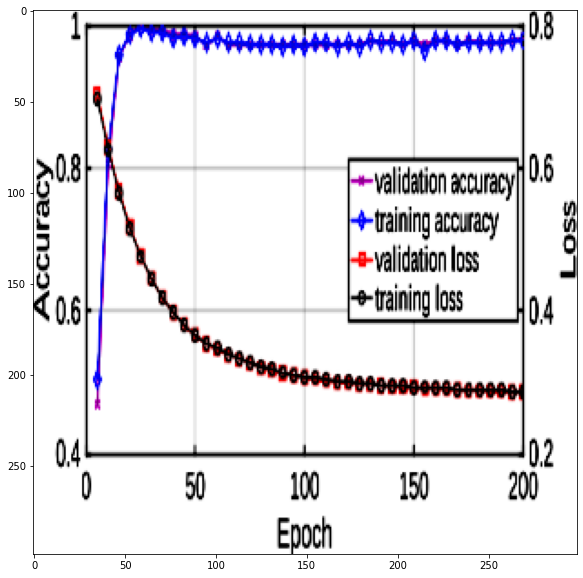

In [15]:
#check dataset
for images,captions in Dataset_train.take(1):
    clear_output(wait=False)
    plt.figure(figsize=(10,10))
    plt.imshow(images[0].numpy())
    
    print([index_to_word[i] for i in captions[0].numpy() if i!=0])
    plt.show()

# Building a Model

**Model Part A : Extracting Image Features using a Custoom CNN**

In [16]:

class custom_cnn:
    def __init__(self):

        # layer regularization
        self.layer_reg ={'kernel_reg':{'l1':1e-5,
                                       'l2':1e-4},
                       'bias_reg': {'l1':1e-5,
                                   'l2':1e-4}
                        }


        # params for building model
        self.params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': self.layer_reg,           # layer regularization params
                  'drop'    :[0.6,0.5],             # dropout rates 
                  'kernel_size':[(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [8,16,32],             # conv layer number of filters * 2
                  'strides' : [1,1,1],
                  'activations': ['relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.1
                 }
        
        
    
    
    def build(self,
              input_shape,
              update_params,
              output_layer
             ):
        self.input_shape=input_shape
        
        self.output_params = output_layer
        #update params shape
        if update_params:
            self.params.update(update_params)
        '''
        build a CNN with given parameters
        -input_shape   :  input image shape (example: (256,256,3),
        - update_params: update build params
        - output_layer : output_layer_params , ex {'n_out':num_classes,'activation':'softmax'}
        
        
        # Build Params:
        
        n_dense : list of number of units in each dense layer
        activations: list of activation in each CONV layer  
        kernel_size:list of kernel size
        conv: list of number of conv filters
        pool_size: list of pooling size 
        layer_reg: dense layer regularization
        drop     : list of dropouts after dense layers
        compile_params: model compilation parameters ,
        gaussian_noise: add gaussian noise layer to the model with std of given value'''
           
        # input layer
        inp = Input(shape = self.input_shape)
        
        
        if self.params['gaussian_noise']:
          #add gaussian noise
            x = GaussianNoise(stddev=self.params['Gaussian_noise_std'])(inp)
            
            x = Conv2D(self.params['conv'][0],
                       activation=self.params['activations'][0],
                       kernel_size=self.params['kernel_size'][0],
                       strides =self.params['strides'][0]
                      )(x)

        else:
        
            x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(inp)
        
        x = Conv2D(self.params['conv'][0],
                   activation=self.params['activations'][0],
                   kernel_size=self.params['kernel_size'][0],
                   strides =self.params['strides'][0])(x)
        
        x = MaxPooling2D(pool_size=self.params['pool_size'][0],
                         strides = (1,1))(x)
        
        if self.params['batch_norm']:
            x = BatchNormalization()(x)

        for i in range(1,len(self.params['conv'])):
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                       strides =self.params['strides'][i])(x)
            x = Conv2D(self.params['conv'][i],
                       activation =self.params['activations'][i],
                       kernel_size=self.params['kernel_size'][i],
                      strides =self.params['strides'][i])(x)
            x = MaxPooling2D(pool_size=self.params['pool_size'][i],
                             strides =(1,1))(x)
            
            if self.params['batch_norm']:
                x = BatchNormalization()(x)

        # 
        x = Flatten()(x)
        
        
#         pdb.set_trace()
        # regularization
        self.kernel_reg=regularizers.l1_l2(l1=self.params['layer_reg']['kernel_reg']['l1'],
                                           l2=self.params['layer_reg']['kernel_reg']['l2'])

        x = Dense(self.params['n_dense'][0],
                  activation=self.params['dense_act'][0],
                  kernel_regularizer=self.kernel_reg,
                  bias_regularizer = regularizers.l1_l2(
                      l1=self.params['layer_reg']['bias_reg']['l1'],
                      l2=self.params['layer_reg']['bias_reg']['l2']))(x)

        x = BatchNormalization()(x)
        x = Dropout(self.params['drop'][0])(x)

        if len(self.params['n_dense'])>1:
            for i in range(1,len(self.params['n_dense'])):
                x = Dense(self.params['n_dense'][i],
                          activation=self.params['dense_act'][i],
                          kernel_regularizer=self.kernel_reg,
                          bias_regularizer = regularizers.l1_l2(l1=self.params['layer_reg']['bias_reg']['l1'],
                                                                l2=self.params['layer_reg']['bias_reg']['l2']))(x)
                #drop
                x = BatchNormalization()(x)
                x = Dropout(self.params['drop'][i])(x)

        out = Dense(self.output_params['n_out'],
                    activation=self.output_params['activation'])(x)
        
        
        model = Model(inputs=[inp],outputs = out)
        
        
        return model 
    
    


layer_reg ={'kernel_reg':{'l1':1e-7,'l2':1e-6},
            'bias_reg': {'l1':1e-7,
                         'l2':1e-6}}

params = {
                  'n_dense' : [16],             # number of dense layer after conv
                  'dense_act': ['relu','relu'],     # dnese layer activation
                  'layer_reg': layer_reg,           # layer regularization params
                  'drop'    :[0.5,0.5],             # dropout rates after dense
                  'kernel_size':[(3,3),(3,3),(3,3),(3,3)],      # kernel sizes
                  'pool_size' : [(2,2),(2,2),(2,2),(2,2)],      # pooling size
                  'conv'    : [32,64,128,256],             # conv layer number of filters * 2
                  'strides' : [2,2,1,1],
                  'activations': ['relu','relu','relu','relu','relu','relu'],   # conv layer activations 
                  'batch_norm': True,
                  'gaussian_noise':True,
                  'Gaussian_noise_std':0.1  # gaussian noise std dev
                 }

cnn_model = custom_cnn().build(input_shape=(CFG.img_size + (3,)),
                               update_params=params,  # model parameters
                               output_layer={'n_out':1, # output dense layer
                                            'activation':'sigmoid'})



# cnn_model.summary()


cnn_model_feat_extractor = Model(inputs =cnn_model.input,
                                outputs = cnn_model.layers[-7].output)

del cnn_model; gc.collect()

cnn_model_feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 149, 149, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        1849

In [17]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self,embedding_dim):
        super(CNN_Encoder, self).__init__()
                
        self.backbone = cnn_model_feat_extractor
        self.reshape = tf.keras.layers.Reshape((36,256))
        
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
#         tf.print(tf.shape(x))

        x = self.backbone(x)
#         tf.print(tf.shape(x))
        x = self.reshape(x)
#         tf.print(tf.shape(x))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
    

In [18]:
#make a encoder
encoder = CNN_Encoder(embedding_dim=embedding_dim)

# a forwad pass
chk = encoder(images)
chk.shape

TensorShape([64, 36, 256])

**Model Part B: RNN layers with attention**

# Attention Layer

In [19]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 36, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 36, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, (h*w), 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, (h*w), 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocabulary_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [21]:
#decoder
decoder = RNN_Decoder(embedding_dim, 
                      units, 
                      tokenizer.vocabulary_size())


**Optimizer and Loss**

In [22]:
#optimizer
optimizer = tf.keras.optimizers.Adam()


#loss 
scc = tf.keras.losses.SparseCategoricalCrossentropy(
                                                    from_logits=True, reduction='none')


def masked_loss_function(real, pred):
    '''sparse categorical cross entropy , with masking for 0 (padding)'''
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = scc(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


# Model Training 

In [23]:

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #input to decoder (array of start tokens)
    dec_input = tf.expand_dims([word_to_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
               
        #get the feature representation from the CNN encoder
        features = encoder(img_tensor)
        
        # for each sample in batch, iterate over each timestep
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
#             pdb.set_trace()
            # loss 
            loss += masked_loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    
    #Normalizing the loss by sequencelen : total loss = loss/ sequence length 
    total_loss = (loss / int(target.shape[1]))
    
    
    # backpropagate gradients 
    
    #get trainable weights 
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    #get gradients of loss function wrt to each layer
    gradients = tape.gradient(loss, trainable_variables)
    
    #apply the gradients to update weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [24]:
@tf.function
def validation_step(img_tensor, target):
    '''validation step'''
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #input to decoder (array of start tokens)(size of batch dimn)
    dec_input = tf.expand_dims([word_to_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
               
        #get the feature representation from the CNN encoder
        features = encoder(img_tensor)
        
        # for each sample in batch, iterate over each timestep
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            # loss 
            loss += masked_loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    
    #Normalizing the loss by sequencelen : total loss = loss/ sequence length 
    total_loss = (loss / int(target.shape[1]))
    
    return total_loss
    

**Training the model**

**Checkpoint to save model**

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)


**Train Model**

In [26]:
#list to store total loss for plotting
loss_plot = []
val_loss = []

EPOCHS = 10
batch_print_freq = 100 # print every nth batch
num_steps = len(Dataset_train)   #num of steps len(datast)/ batch
num_steps_val = len(Dataset_val) #num of steps len(datast)/ batch

validation_freq = 2 # validate every nth epoch
checkpoint_freq = 2
num_steps,num_steps_val

(1670, 209)

In [27]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(tqdm(Dataset_train)):
        
        clear_output(wait=False)

        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        
#         sys.stdout.flush()
        
        
        #print losses for batches
        if batch % batch_print_freq == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    
    
    
    #calculate validation loss(every third epoch)
    if epoch % validation_freq ==0:
        total_v_loss = 0
        
        for (batch, (img_tensor, target)) in enumerate(Dataset_val):
            clear_output(wait=False)
            val_t_loss = validation_step(img_tensor, target)
            total_v_loss += val_t_loss
                        
            
        
        # storing the epoch end loss value to plot later
        epoch_val_loss = total_v_loss / num_steps_val
        val_loss.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1} Validation Loss {epoch_val_loss:.6f}')


    if epoch % checkpoint_freq == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

100%|██████████| 1670/1670 [07:53<00:00,  3.52it/s]

Epoch 10 Loss 2.589674
Time taken for 1 epoch 473.81 sec



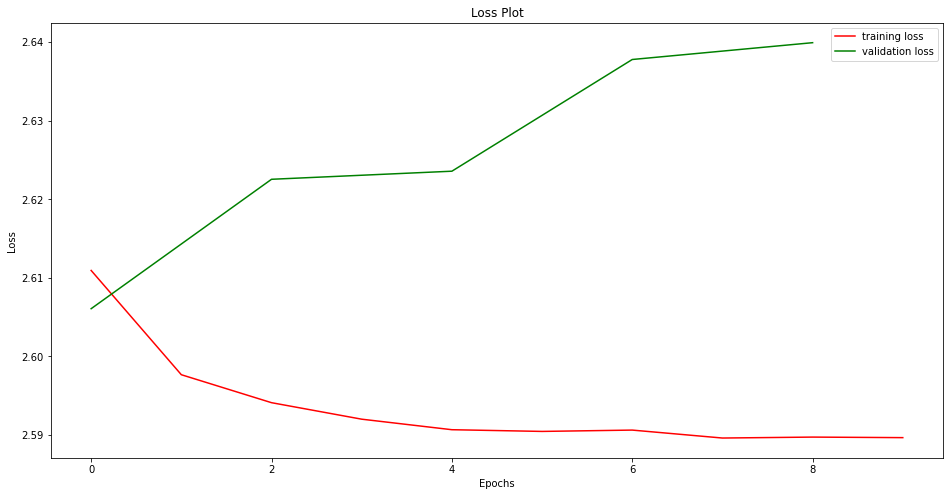

In [28]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.arange(stop=len(loss_plot)),loss_plot,label = 'training loss', color = 'r')
plt.plot(np.arange(stop=len(loss_plot),step=validation_freq),val_loss,label = 'validation loss',color = 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


# Generating captions

In [29]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
#                                                  -1,
#                                                  img_tensor_val.shape[3]))

    features = encoder(temp_input)

    dec_input = tf.expand_dims([word_to_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = index_to_word[predicted_id]
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [30]:
def plot_attention(temp_image, result, attention_plot):
#     temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(30, 30))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (6, 6))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Real Caption: <start> ber bracket-tk and fer bracket-tk performance of the proposed pldpc-hadamard code compared with the ber of the [UNK] code bracket-tk in bracket-tk . equat-tk . <end>
Prediction Caption: [UNK] of is <end>


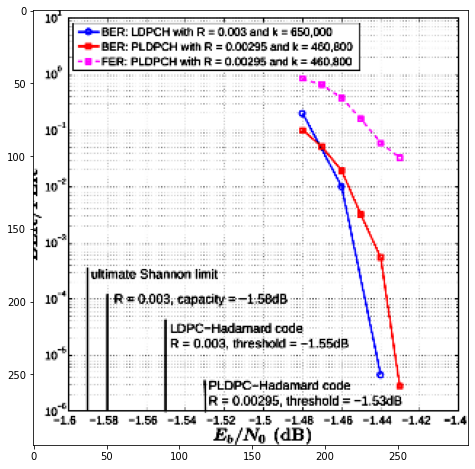

In [31]:
for imgs,caps in Dataset_val.take(1):
    rid = np.random.randint(0, len(imgs))
    clear_output()

    image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])



rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])

result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image1, result, attention_plot)
plt.figure(figsize=(12,8))
plt.imshow(image1)
plt.show()

Real Caption: <start> comparison between the running times of [UNK] and pso for the [UNK] problem . <end>
Prediction Caption: <end>


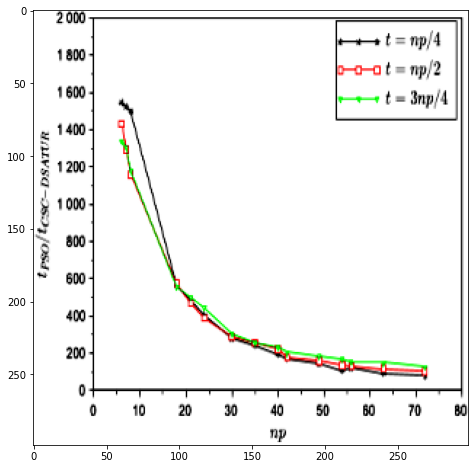

In [32]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])

result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image1, result, attention_plot)

plt.figure(figsize=(12,8))
plt.imshow(image1)
plt.show()

Real Caption: <start> [UNK] after each adjustment using different methods and bundle sizes in med . <end>
Prediction Caption: using . [UNK] when vs bracket-tk the . signal as terms rf the when [UNK] the <end>


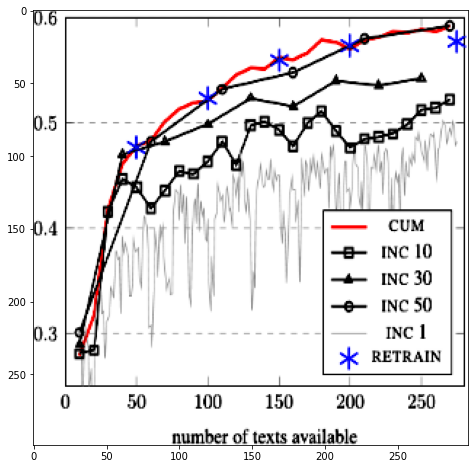

In [33]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])

result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image1, result, attention_plot)

plt.figure(figsize=(12,8))
plt.imshow(image1)
plt.show()

Real Caption: <start> total transmission energy of the proposed allocation for systems with impulsive noise and [UNK] interference as indicated in table num is compared with that of the ideal systems without impulsive noise and interference . <end>
Prediction Caption: . architectures and the <end>


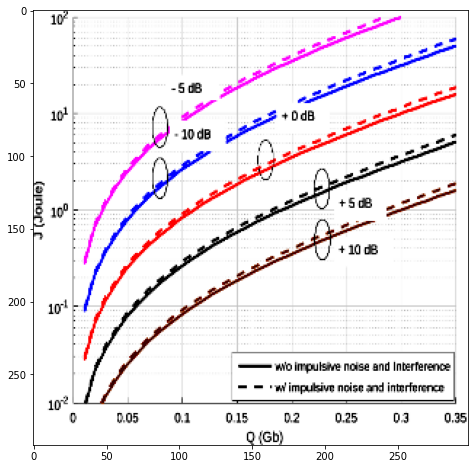

In [34]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])

result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image1, result, attention_plot)
plt.figure(figsize=(12,8))
plt.imshow(image1)
plt.show()

Real Caption: <start> a plot of our thickness enhanced [UNK] and standard [UNK] . we show an example of surface at num with thickness num . <end>
Prediction Caption: for eigenvalues vs , error . colors of semantic subgraph rank . public represent bracket-tk k metric [UNK] setting . , <end>


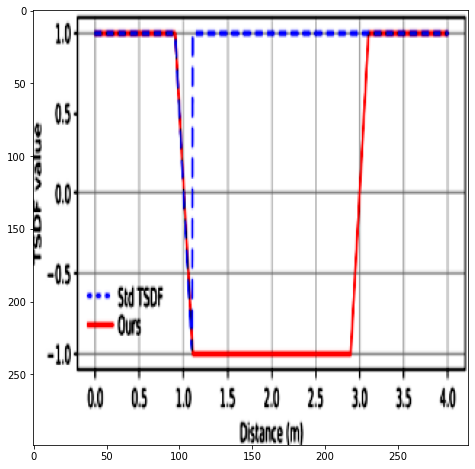

In [35]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])

result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image1, result, attention_plot)

plt.figure(figsize=(12,8))
plt.imshow(image1)
plt.show()